In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('./data/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [6]:
algo_name = 'lgbcv'
feature_name = 'stacking'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [10]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(data_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(data_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [11]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

In [12]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [68]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=3000,
                             num_leaves=64,
                             learning_rate=0.03,
                             min_child_samples=256,
                             subsample=.7,
                             subsample_freq=1,
                             colsample_bytree=.7,
                             random_state=17,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=100)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.938788
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.896081
[3]	valid_0's multi_logloss: 0.856243
[4]	valid_0's multi_logloss: 0.819386
[5]	valid_0's multi_logloss: 0.785222
[6]	valid_0's multi_logloss: 0.75335
[7]	valid_0's multi_logloss: 0.723586
[8]	valid_0's multi_logloss: 0.695746
[9]	valid_0's multi_logloss: 0.669787
[10]	valid_0's multi_logloss: 0.645262
[11]	valid_0's multi_logloss: 0.622219
[12]	valid_0's multi_logloss: 0.600491
[13]	valid_0's multi_logloss: 0.579945
[14]	valid_0's multi_logloss: 0.560556
[15]	valid_0's multi_logloss: 0.542203
[16]	valid_0's multi_logloss: 0.52485
[17]	valid_0's multi_logloss: 0.508383
[18]	valid_0's multi_logloss: 0.492831
[19]	valid_0's multi_logloss: 0.478092
[20]	valid_0's multi_logloss: 0.464075
[21]	valid_0's multi_logloss: 0.450835
[22]	valid_0's multi_logloss: 0.438171
[23]	valid_0's multi_logloss: 0.42621
[24]	valid_0's multi_logloss

[212]	valid_0's multi_logloss: 0.158939
[213]	valid_0's multi_logloss: 0.158923
[214]	valid_0's multi_logloss: 0.158906
[215]	valid_0's multi_logloss: 0.158906
[216]	valid_0's multi_logloss: 0.15889
[217]	valid_0's multi_logloss: 0.158875
[218]	valid_0's multi_logloss: 0.158858
[219]	valid_0's multi_logloss: 0.158842
[220]	valid_0's multi_logloss: 0.15883
[221]	valid_0's multi_logloss: 0.158812
[222]	valid_0's multi_logloss: 0.158794
[223]	valid_0's multi_logloss: 0.158777
[224]	valid_0's multi_logloss: 0.158771
[225]	valid_0's multi_logloss: 0.158762
[226]	valid_0's multi_logloss: 0.158758
[227]	valid_0's multi_logloss: 0.158754
[228]	valid_0's multi_logloss: 0.158744
[229]	valid_0's multi_logloss: 0.158734
[230]	valid_0's multi_logloss: 0.15872
[231]	valid_0's multi_logloss: 0.158708
[232]	valid_0's multi_logloss: 0.158702
[233]	valid_0's multi_logloss: 0.158694
[234]	valid_0's multi_logloss: 0.15868
[235]	valid_0's multi_logloss: 0.158673
[236]	valid_0's multi_logloss: 0.158668
[237

[50]	valid_0's multi_logloss: 0.247515
[51]	valid_0's multi_logloss: 0.244186
[52]	valid_0's multi_logloss: 0.24098
[53]	valid_0's multi_logloss: 0.237884
[54]	valid_0's multi_logloss: 0.234923
[55]	valid_0's multi_logloss: 0.232095
[56]	valid_0's multi_logloss: 0.229401
[57]	valid_0's multi_logloss: 0.226803
[58]	valid_0's multi_logloss: 0.224322
[59]	valid_0's multi_logloss: 0.221927
[60]	valid_0's multi_logloss: 0.21963
[61]	valid_0's multi_logloss: 0.217414
[62]	valid_0's multi_logloss: 0.215307
[63]	valid_0's multi_logloss: 0.213273
[64]	valid_0's multi_logloss: 0.211316
[65]	valid_0's multi_logloss: 0.209453
[66]	valid_0's multi_logloss: 0.207666
[67]	valid_0's multi_logloss: 0.205929
[68]	valid_0's multi_logloss: 0.204259
[69]	valid_0's multi_logloss: 0.202663
[70]	valid_0's multi_logloss: 0.201145
[71]	valid_0's multi_logloss: 0.199648
[72]	valid_0's multi_logloss: 0.198235
[73]	valid_0's multi_logloss: 0.196883
[74]	valid_0's multi_logloss: 0.195577
[75]	valid_0's multi_loglos

[261]	valid_0's multi_logloss: 0.159567
[262]	valid_0's multi_logloss: 0.159556
[263]	valid_0's multi_logloss: 0.159556
[264]	valid_0's multi_logloss: 0.159568
[265]	valid_0's multi_logloss: 0.159564
[266]	valid_0's multi_logloss: 0.159574
[267]	valid_0's multi_logloss: 0.159581
[268]	valid_0's multi_logloss: 0.159558
[269]	valid_0's multi_logloss: 0.159558
[270]	valid_0's multi_logloss: 0.159548
[271]	valid_0's multi_logloss: 0.159553
[272]	valid_0's multi_logloss: 0.159554
[273]	valid_0's multi_logloss: 0.159561
[274]	valid_0's multi_logloss: 0.159569
[275]	valid_0's multi_logloss: 0.159582
[276]	valid_0's multi_logloss: 0.15959
[277]	valid_0's multi_logloss: 0.159606
[278]	valid_0's multi_logloss: 0.159622
[279]	valid_0's multi_logloss: 0.159621
[280]	valid_0's multi_logloss: 0.159623
[281]	valid_0's multi_logloss: 0.159637
[282]	valid_0's multi_logloss: 0.159635
[283]	valid_0's multi_logloss: 0.159647
[284]	valid_0's multi_logloss: 0.159638
[285]	valid_0's multi_logloss: 0.159635
[

[96]	valid_0's multi_logloss: 0.177414
[97]	valid_0's multi_logloss: 0.176867
[98]	valid_0's multi_logloss: 0.176326
[99]	valid_0's multi_logloss: 0.175803
[100]	valid_0's multi_logloss: 0.175297
[101]	valid_0's multi_logloss: 0.174803
[102]	valid_0's multi_logloss: 0.174316
[103]	valid_0's multi_logloss: 0.173869
[104]	valid_0's multi_logloss: 0.173428
[105]	valid_0's multi_logloss: 0.173017
[106]	valid_0's multi_logloss: 0.17261
[107]	valid_0's multi_logloss: 0.172215
[108]	valid_0's multi_logloss: 0.171832
[109]	valid_0's multi_logloss: 0.17146
[110]	valid_0's multi_logloss: 0.171093
[111]	valid_0's multi_logloss: 0.17075
[112]	valid_0's multi_logloss: 0.170413
[113]	valid_0's multi_logloss: 0.170094
[114]	valid_0's multi_logloss: 0.169784
[115]	valid_0's multi_logloss: 0.169488
[116]	valid_0's multi_logloss: 0.169198
[117]	valid_0's multi_logloss: 0.168903
[118]	valid_0's multi_logloss: 0.168621
[119]	valid_0's multi_logloss: 0.168351
[120]	valid_0's multi_logloss: 0.168095
[121]	v

[306]	valid_0's multi_logloss: 0.159905
[307]	valid_0's multi_logloss: 0.159914
[308]	valid_0's multi_logloss: 0.159927
[309]	valid_0's multi_logloss: 0.159929
[310]	valid_0's multi_logloss: 0.159935
[311]	valid_0's multi_logloss: 0.159937
[312]	valid_0's multi_logloss: 0.159936
[313]	valid_0's multi_logloss: 0.159945
[314]	valid_0's multi_logloss: 0.15995
[315]	valid_0's multi_logloss: 0.159949
[316]	valid_0's multi_logloss: 0.15996
[317]	valid_0's multi_logloss: 0.159962
[318]	valid_0's multi_logloss: 0.15996
[319]	valid_0's multi_logloss: 0.159966
[320]	valid_0's multi_logloss: 0.159972
[321]	valid_0's multi_logloss: 0.159978
[322]	valid_0's multi_logloss: 0.159986
[323]	valid_0's multi_logloss: 0.159997
[324]	valid_0's multi_logloss: 0.159997
[325]	valid_0's multi_logloss: 0.160004
[326]	valid_0's multi_logloss: 0.16001
[327]	valid_0's multi_logloss: 0.16001
[328]	valid_0's multi_logloss: 0.160016
[329]	valid_0's multi_logloss: 0.16002
[330]	valid_0's multi_logloss: 0.160027
[331]	

[125]	valid_0's multi_logloss: 0.167061
[126]	valid_0's multi_logloss: 0.16685
[127]	valid_0's multi_logloss: 0.16664
[128]	valid_0's multi_logloss: 0.166447
[129]	valid_0's multi_logloss: 0.16625
[130]	valid_0's multi_logloss: 0.16607
[131]	valid_0's multi_logloss: 0.165897
[132]	valid_0's multi_logloss: 0.165723
[133]	valid_0's multi_logloss: 0.165559
[134]	valid_0's multi_logloss: 0.165404
[135]	valid_0's multi_logloss: 0.165248
[136]	valid_0's multi_logloss: 0.1651
[137]	valid_0's multi_logloss: 0.164953
[138]	valid_0's multi_logloss: 0.164814
[139]	valid_0's multi_logloss: 0.164679
[140]	valid_0's multi_logloss: 0.164546
[141]	valid_0's multi_logloss: 0.164416
[142]	valid_0's multi_logloss: 0.164291
[143]	valid_0's multi_logloss: 0.164167
[144]	valid_0's multi_logloss: 0.164047
[145]	valid_0's multi_logloss: 0.163923
[146]	valid_0's multi_logloss: 0.16381
[147]	valid_0's multi_logloss: 0.163695
[148]	valid_0's multi_logloss: 0.163584
[149]	valid_0's multi_logloss: 0.16348
[150]	va

[333]	valid_0's multi_logloss: 0.16048
[334]	valid_0's multi_logloss: 0.160478
[335]	valid_0's multi_logloss: 0.160484
[336]	valid_0's multi_logloss: 0.160486
[337]	valid_0's multi_logloss: 0.160491
[338]	valid_0's multi_logloss: 0.1605
[339]	valid_0's multi_logloss: 0.160512
[340]	valid_0's multi_logloss: 0.160524
[341]	valid_0's multi_logloss: 0.160523
[342]	valid_0's multi_logloss: 0.160531
[343]	valid_0's multi_logloss: 0.160532
[344]	valid_0's multi_logloss: 0.160537
[345]	valid_0's multi_logloss: 0.160544
[346]	valid_0's multi_logloss: 0.160545
[347]	valid_0's multi_logloss: 0.160549
[348]	valid_0's multi_logloss: 0.160553
[349]	valid_0's multi_logloss: 0.160553
[350]	valid_0's multi_logloss: 0.160557
[351]	valid_0's multi_logloss: 0.160563
[352]	valid_0's multi_logloss: 0.160564
[353]	valid_0's multi_logloss: 0.160571
[354]	valid_0's multi_logloss: 0.160578
[355]	valid_0's multi_logloss: 0.160578
[356]	valid_0's multi_logloss: 0.160587
[357]	valid_0's multi_logloss: 0.160596
[35

[178]	valid_0's multi_logloss: 0.159949
[179]	valid_0's multi_logloss: 0.159906
[180]	valid_0's multi_logloss: 0.159861
[181]	valid_0's multi_logloss: 0.159807
[182]	valid_0's multi_logloss: 0.159763
[183]	valid_0's multi_logloss: 0.159726
[184]	valid_0's multi_logloss: 0.159689
[185]	valid_0's multi_logloss: 0.159646
[186]	valid_0's multi_logloss: 0.159611
[187]	valid_0's multi_logloss: 0.159569
[188]	valid_0's multi_logloss: 0.159533
[189]	valid_0's multi_logloss: 0.159486
[190]	valid_0's multi_logloss: 0.159442
[191]	valid_0's multi_logloss: 0.159411
[192]	valid_0's multi_logloss: 0.159382
[193]	valid_0's multi_logloss: 0.159347
[194]	valid_0's multi_logloss: 0.15932
[195]	valid_0's multi_logloss: 0.159289
[196]	valid_0's multi_logloss: 0.159261
[197]	valid_0's multi_logloss: 0.15924
[198]	valid_0's multi_logloss: 0.159215
[199]	valid_0's multi_logloss: 0.159193
[200]	valid_0's multi_logloss: 0.159173
[201]	valid_0's multi_logloss: 0.159145
[202]	valid_0's multi_logloss: 0.15912
[20

In [69]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3859%


In [70]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [71]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [72]:
clf.coef_.shape

AttributeError: 'LGBMClassifier' object has no attribute 'coef_'

<AxesSubplot:ylabel='feature'>

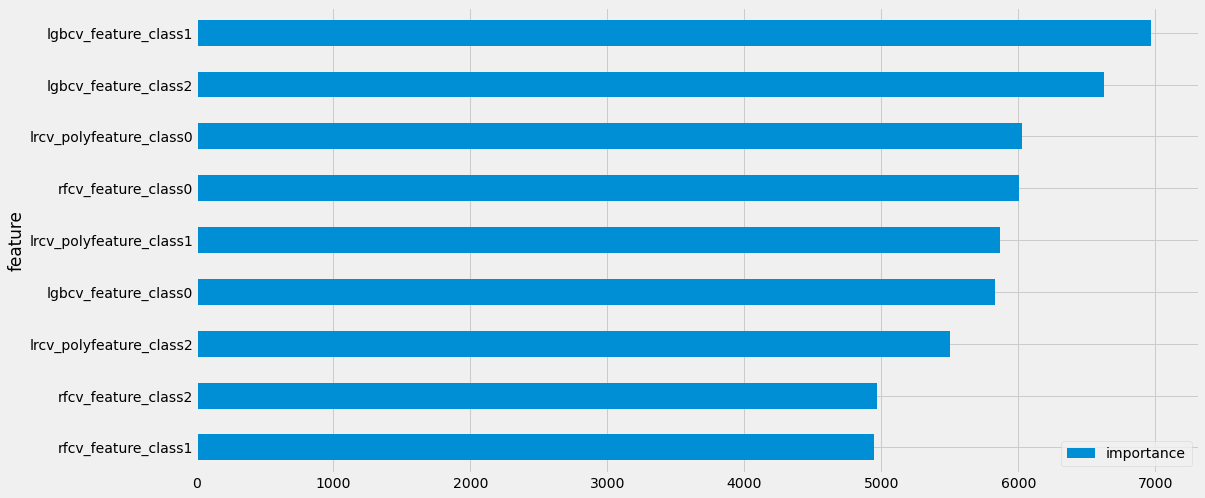

In [73]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [74]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [75]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [76]:
sub[target_col].value_counts()

2    40825
0    29988
1     9187
Name: class, dtype: int64

In [77]:
sub.to_csv(sub_file)